In [ ]:
# Copyright Elasticsearch B.V. and/or licensed to Elasticsearch B.V. under one
# or more contributor license agreements. Licensed under the Elastic License;
# you may not use this file except in compliance with the Elastic License.

# Scenario 1: Data summarization

1. Train model (M1) on the complete dataset (D1)

2. Generate a summarization dataset using some technique (D2)

3. Train a new model (M2) on D2
    1. Use the same best hyperparameters as for M1   
    2. **Identify a new set of best hyperparameters**
    
4. Compare M1 and M2
    1. Evaluation M1 and M2 on the complete dataset D1.
    2. Evaluate M1 and M2 on a grid and compute divergence
    3. Compare feature importance vectors for individual data points from M1 and M2 (should be very similar)
    4. Compare errors on the test dataset (D3)

**Notes:**
- We assume that generation of a summarization dataset is implemented. It can be written in Python for prototyping.
- 4 can be done with an inference pipeline and eland
- We need a simple way to query a model using inference pipeline (e.g. Python wrapper?)
- Evaluations can also be done with sklearn?
- What is the minimum amount of data we can get away with?


In [9]:
%config Completer.use_jedi = False
import json
import tempfile
import platform
import time
import string
import random

import pandas as pd
import numpy as np
import diversipy
import libtmux 

from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error


# I assume, your host OS is not CentOS
cloud = (platform.system() == 'Linux') and (platform.dist()[0] == 'centos')
if cloud:
    mlcpp_root = '/ml-cpp'
else:
    import os
    system = '{}-{}'.format(platform.system().lower(), platform.machine().lower())
    mlcpp_root = os.environ['CPP_SRC_HOME']+'/build/distribution/platform/{}'.format(system)
dfa_path = mlcpp_root+'/bin/data_frame_analyzer'

server = libtmux.Server()

In [10]:
def get_predictions(results):
    predictions = []
    for item in results:
        if 'row_results' in item:
            predictions.append(item['row_results']['results']['ml']['54_prediction'])
    return np.array(predictions)

In [11]:
def get_hyperparameters(results):
    hyperparameters = {}
    for item in results:
        if 'model_metadata' in item:
            for hyperparameter in item['model_metadata']['hyperparameters']:
                hyperparameters[hyperparameter['name']] = hyperparameter['value']
    return hyperparameters

In [12]:
def run_job(input, config, persist=None, restore=None):
    output = tempfile.NamedTemporaryFile(mode='wt')
    job_suffix = ''.join(random.choices(string.ascii_lowercase, k=5))
    job_name = 'job_{}'.format(job_suffix)
    cmd = [dfa_path,
    "--input", input,
    "--config", config,
    "--output", output.name]
    
    
    if persist:
        cmd += ["--persist", persist]
    if restore:
        cmd += ['--restore', restore]
 
    cmd = ' '.join(cmd)
    
    session = server.new_session(job_name)
    window = session.new_window(attach=False)
    pane = window.split_window(attach=False)
    
    print("session: {}\tcommand:\n{}".format(session.get('session_name'), cmd))
    pane.send_keys(cmd)
    return {'name': job_name, 'pane': pane, 'output': output}

In [13]:
def wait_job_complete(job):
    pane = job['pane']
    output = job['output']
    while True :
        display.clear_output(wait=True)
        err = "\n".join(pane.capture_pane())
        out =  !grep "phase_progress" $output.name | tail -n10 
        out = "\n".join(out)
        display.display_html(display.HTML("""<table><tr>
                                                    <td width="50%" style="text-align:center;"><b>stderr</b></td>
                                                    <td width="50%" style="text-align:center;"><b>output</b></td>
                                                    </tr>
                                                    <tr>
                                                    <td width="50%" style="text-align:left;"><pre>{}</pre></td>
                                                    <td width="50%" style="text-align:left;"><pre>{}</pre></td>
                                                    </tr>
                                            </table>"""
                                 .format(err, out)))
        # the line in main.cc where final output is produced
        if sum(['Main.cc@246' in line for line in pane.capture_pane()[-5:]]) == 1:
            break
        time.sleep(5.0)
    with open(output.name) as fp:
        results = json.load(fp)
    # clean up
    output.close()
    server.kill_session(target_session=job['name'])
    return results

## 1. Train model (M1) on the complete dataset (D1)

In [14]:
job = run_job(input="datasets/facebook_6000.csv", 
              config="configs/facebook_6000.json",
              persist="model1.json")

session: job_ejjzh	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000.csv --config configs/facebook_6000.json --output /tmp/tmpooiyg85v --persist model1.json


In [15]:
results = wait_job_complete(job)

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000.csv --config configs/facebook_6000.json --output /tmp/tmpooiyg85v --persist model1.json
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 2…9⚑ 3]
13:31 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000.csv --config configs/facebook_6000.json --output /tmp/tmpooiyg85v --persist model1.json
2021-03-05 12:31:33,968219 UTC [9913] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version 8.0.0-SNAPSHOT (Build 93946a5deec802) Copyright (c) 2021 Elasticsearch BV
2021-03-05 12:31:33,968395 UTC [9913] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-03-05 12:31:33,968433 UTC [9913] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-03-05 12:31:33,970915 UTC [9913] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-03-05 12:31:34,026960 UTC [9913] DEBUG CDataFrameAnalyzer.cc@104 Received 6000 rows
2021-03-05 12:35:34,629086 UTC [9913] INFO CBoostedTreeImpl.cc@237 Exiting hyperparameter optimisation loop early
2021-03-05 12:35:41,907840 UTC [9913] INFO Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":44908914}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":41530066}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":246836}
,{"name":"E_DFTPMTrainedForestNumberTrees","description":"The total number of trees in the trained forest","value":255}
]
2021-03-05 12:35:41,907959 UTC [9913] DEBUG Main.cc@246 ML data frame analyzer exiting
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 3…10⚑ 3]
13:35 $ 
 ,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":0}}
,{"phase_progress":{"phase":"final_training","progress_percent":19}}
,{"phase_progress":{"phase":"final_training","progress_percent":43}}
,{"phase_progress":{"phase":"final_training","progress_percent":61}}
,{"phase_progress":{"phase":"final_training","progress_percent":75}}
,{"phase_progress":{"phase":"final_training","progress_percent":90}}
,{"phase_progress":{"phase":"final_training","progress_percent":99}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}

In [16]:
# keep only the last checkpoint with the final model
!echo "$(tail -n 3 model1.json)" > model1.json

/bin/bash: warning: command substitution: ignored null byte in input


## 2. Generate a sumarization dataset

In [17]:
dataset = pd.read_csv('datasets/facebook_6000.csv')
summarization = diversipy.subset.psa_select(dataset.to_numpy(), 1000)
summarization_df = pd.DataFrame(data=summarization, columns=dataset.columns)

In [18]:
# update config with the new number of rows
with open('configs/facebook_6000.json') as f:
    config = json.load(f)
config['rows'] = summarization_df.shape[0]

## 3. A. Train a new model with the same best best hyperparameters

In [19]:
hyperparameters = get_hyperparameters(results)
config['analysis']['parameters'] = { **config['analysis']['parameters'], **hyperparameters}

fconfig = tempfile.NamedTemporaryFile(mode='wt')
fdata = tempfile.NamedTemporaryFile(mode='wt')
json.dump(config, fconfig)
fconfig.file.close()
summarization_df.to_csv(fdata, index=False)
fdata.file.close()
job = run_job(input=fdata.name, config=fconfig.name, persist="model2.json")

session: job_khdaq	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmp_ep_idgj --config /tmp/tmp0rf7f0ty --output /tmp/tmp2we44l9f --persist model2.json


In [20]:
results = wait_job_complete(job)

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmp_ep_idgj --config /tmp/tmp0rf7f0ty --output /tmp/tmp2we44l9f --persist model2.json
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 3…10⚑ 3]
13:35 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmp_ep_idgj --config /tmp/tmp0rf7f0ty --output /tmp/tmp2we44l9f --persist model2.json
2021-03-05 12:35:56,384421 UTC [27890] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version 8.0.0-SNAPSHOT (Build 93946a5deec802) Copyright (c) 2021 Elasticsearch BV
2021-03-05 12:35:56,384579 UTC [27890] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-03-05 12:35:56,384609 UTC [27890] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-03-05 12:35:56,385725 UTC [27890] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-03-05 12:35:56,395654 UTC [27890] DEBUG CDataFrameAnalyzer.cc@104 Received 1000 rows
2021-03-05 12:36:29,564964 UTC [27890] INFO CBoostedTreeImpl.cc@237 Exiting hyperparameter optimisation loop early
2021-03-05 12:36:31,233772 UTC [27890] INFO Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":28459411}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":1112628}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":33925}
,{"name":"E_DFTPMTrainedForestNumberTrees","description":"The total number of trees in the trained forest","value":172}
]
2021-03-05 12:36:31,233889 UTC [27890] DEBUG Main.cc@246 ML data frame analyzer exiting
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 3…11⚑ 3]
13:36 $ 
 ,{"phase_progress":{"phase":"feature_selection","progress_percent":100}}
,{"phase_progress":{"phase":"coarse_parameter_search","progress_percent":100}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":3}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":25}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":60}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":80}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":85}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}

In [21]:
fconfig.close()
fdata.close()

# keep only the last checkpoint with the final model
!echo "$(tail -n 3 model2.json)" > model2.json

/bin/bash: warning: command substitution: ignored null byte in input


## 3. B. Train a new model with new best hyperparameters

In [14]:
fconfig = tempfile.NamedTemporaryFile(mode='wt')
fdata = tempfile.NamedTemporaryFile(mode='wt')
json.dump(config, fconfig)
fconfig.file.close()
summarization_df.to_csv(fdata, index=False)
fdata.file.close()
job = run_job(input=fdata.name, config=fconfig.name, persist="model2.json")

session: job_xbmzv	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpteocz31h --config /tmp/tmp2od10o5o --output /tmp/tmp6q1fs68x --persist model2.json


In [15]:
results = wait_job_complete(job)

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpteocz31h --config /tmp/tmp2od10o5o --output /tmp/tmp6q1fs68x --persist model2.json
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [jupyter-docker|✚ 1…6⚑ 3]
13:02 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpteocz31h --config /tmp/tmp2od10o5o --output /tmp/tmp6q1fs68x --persist model2.json
2021-02-24 12:02:36,363774 UTC [19273] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-02-24 12:02:36,363809 UTC [19273] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-02-24 12:02:36,363822 UTC [19273] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-02-24 12:02:36,364207 UTC [19273] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-02-24 12:02:36,364345 UTC [19273] WARN CBoostedTreeFactory.cc@1205 Minimum tree depth must be at least two
2021-02-24 12:02:36,369719 UTC [19273] DEBUG CDataFrameAnalyzer.cc@104 Received 1000 rows
2021-02-24 12:02:50,526065 UTC [19273] WARN CBoostedTreeImpl.cc@245 Hyperparameter selection failed: exiting loop early
2021-02-24 12:02:50,718087 UTC [19273] INFO Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":22227692}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":1338057}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":14196}
,{"name":"E_DFTPMTrainedForestNumberTrees","description":"The total number of trees in the trained forest","value":23}
]
2021-02-24 12:02:50,718194 UTC [19273] DEBUG Main.cc@246 ML data frame analyzer exiting 
 ,{"phase_progress":{"phase":"feature_selection","progress_percent":15}}
,{"phase_progress":{"phase":"feature_selection","progress_percent":30}}
,{"phase_progress":{"phase":"feature_selection","progress_percent":50}}
,{"phase_progress":{"phase":"feature_selection","progress_percent":75}}
,{"phase_progress":{"phase":"feature_selection","progress_percent":99}}
,{"phase_progress":{"phase":"feature_selection","progress_percent":100}}
,{"phase_progress":{"phase":"coarse_parameter_search","progress_percent":100}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}

In [16]:
fconfig.close()
fdata.close()

# keep only the last checkpoint with the final model
!echo "$(tail -n 3 model2.json)" > model2.json

/bin/bash: warning: command substitution: ignored null byte in input


## 4. A. Compare M1 and M2 on D1

In [17]:
## removing targets is strictly speaking not necessary. This is just to show that we can evaluate on an 
## arbitrary new dataset
df = pd.read_csv("datasets/facebook_6000.csv")
y_true = df['54']
df['54'] = np.nan
df.to_csv('datasets/facebook_6000_notarget.csv', index=False)

In [18]:
job = run_job(input="datasets/facebook_6000_notarget.csv",
             config="configs/facebook_6000.json",
             restore="model1.json")

session: job_nzjey	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000_notarget.csv --config configs/facebook_6000.json --output /tmp/tmpu_gde3_0 --restore model1.json


In [19]:
evaluate_m1_results = wait_job_complete(job)

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000_notarget.csv --config configs/facebook_6000.json --output /tmp/tmpu_gde3_0 --restore model1.json
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [jupyter-docker|✚ 1…6⚑ 3]
13:02 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000_notarget.csv --config configs/facebook_6000.json --output /tmp/tmpu_gde3_0 --restore model1.json
2021-02-24 12:02:51,943749 UTC [21437] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-02-24 12:02:51,943793 UTC [21437] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-02-24 12:02:51,943804 UTC [21437] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-02-24 12:02:51,944158 UTC [21437] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-02-24 12:02:51,974707 UTC [21437] DEBUG CDataFrameAnalyzer.cc@104 Received 6000 rows
2021-02-24 12:02:51,978857 UTC [21437] DEBUG CStateDecompressor.cc@168 Explicit end-of-stream marker found in document with index 1
2021-02-24 12:02:52,110327 UTC [21437] WARN CBoostedTreeImpl.cc@245 Hyperparameter selection failed: exiting loop early
2021-02-24 12:02:52,269816 UTC [21437] INFO Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":44908909}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":2205978}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":148}
,{"name":"E_DFTPMTrainedForestNumberTrees","description":"The total number of trees in the trained forest","value":65}
]
2021-02-24 12:02:52,269926 UTC [21437] DEBUG Main.cc@246 ML data frame analyzer exiting
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [jupyter-docker|✚ 1…6⚑ 3]
13:02 $ 
 ,{"phase_progress":{"phase":"feature_selection","progress_percent":100}}
,{"phase_progress":{"phase":"coarse_parameter_search","progress_percent":100}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":38}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":41}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":43}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}

In [20]:
m1_d1_predictions = get_predictions(evaluate_m1_results)

In [26]:
job = run_job(input="datasets/facebook_6000_notarget.csv",
             config="configs/facebook_6000.json",
             restore="model2.json")

session: job_jjokq	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000_notarget.csv --config configs/facebook_6000.json --output /tmp/tmp4_stn3vb --restore model2.json


In [27]:
evaluate_m2_results = wait_job_complete(job)

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000_notarget.csv --config configs/facebook_6000.json --output /tmp/tmp4_stn3vb --restore model2.json
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 4…11⚑ 3]
14:30 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000_notarget.csv --config configs/facebook_6000.json --output /tmp/tmp4_stn3vb --restore model2.json
2021-03-05 13:30:38,924120 UTC [2918] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-03-05 13:30:38,924185 UTC [2918] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-03-05 13:30:38,924201 UTC [2918] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-03-05 13:30:38,924872 UTC [2918] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-03-05 13:30:38,971622 UTC [2918] DEBUG CDataFrameAnalyzer.cc@104 Received 6000 rows
2021-03-05 13:30:38,979718 UTC [2918] DEBUG CStateDecompressor.cc@168 Explicit end-of-stream marker found in document with index 1
2021-03-05 13:30:39,104109 UTC [2918] INFO CBoostedTreeImpl.cc@237 Exiting hyperparameter optimisation loop early
2021-03-05 13:30:39,250632 UTC [2918] INFO Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":44908914}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":1982586}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":208}
,{"name":"E_DFTPMTrainedForestNumberTrees","description":"The total number of trees in the trained forest","value":172}
]
2021-03-05 13:30:39,250681 UTC [2918] DEBUG Main.cc@246 ML data frame analyzer exiting
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks [summarization-runs|✚ 4…11⚑ 3]
14:30 $ 
 ,{"phase_progress":{"phase":"feature_selection","progress_percent":100}}
,{"phase_progress":{"phase":"coarse_parameter_search","progress_percent":100}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":0}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":19}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":39}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":79}}
,{"phase_progress":{"phase":"fine_tuning_parameters","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}
,{"phase_progress":{"phase":"final_training","progress_percent":100}}

In [23]:
m2_d1_predictions = get_predictions(evaluate_m2_results)

In [24]:
def compute_metrics(ytrue, m1pred, m2pred):
    m1_mae = mean_absolute_error(ytrue, m1pred)
    m1_mse = mean_squared_error(ytrue, m1pred)
    m2_mae = mean_absolute_error(ytrue, m2pred)
    m2_mse = mean_squared_error(ytrue, m2pred)
    print("M1: MAE: {}\tMSE:{}".format(m1_mae, m1_mse))
    print("M2: MAE: {}\tMSE:{}".format(m2_mae, m2_mse))
    ax = sns.scatterplot(x=m1pred, y=m2pred)
    plt.xlabel('M1 predictions')
    plt.ylabel('M2 predictions')

M1: MAE: 3.4217911224892985	MSE:115.9036311437287
M2: MAE: 4.4619627041021985	MSE:201.30564997497368


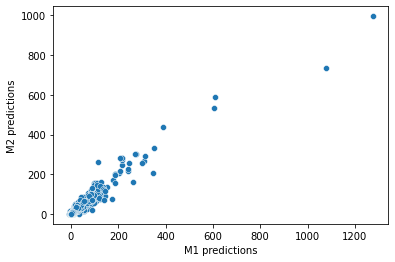

In [25]:
compute_metrics(y_true, m1_d1_predictions, m2_d1_predictions)